### Trajectory tracking of `Snapbot` using PID control 

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from mujoco_parser import MuJoCoParserClass
from pid import PID_ControllerClass
from grp import GaussianRandomPathClass
from snapbot_util import get_snapbot_q,wait_until_snapbot_on_ground
from util import soft_squash_multidim,get_colors,r2rpy,kernel_levse,plot_topdown_trajectory,get_anchors_from_traj
print ("Done.")

Done.


### Instantiate Gaussian random path

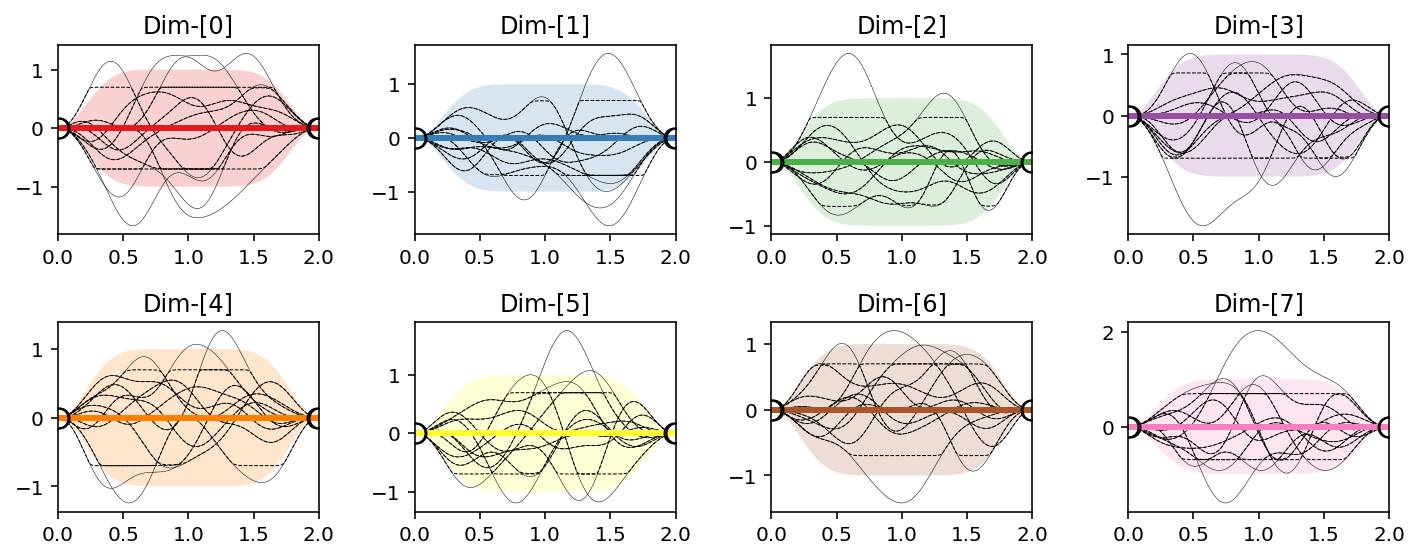

In [2]:
dur_sec = 2.0
env = MuJoCoParserClass(name='Snapbot',rel_xml_path='../asset/snapbot/robot_4_1245.xml',VERBOSE=False)
PID = PID_ControllerClass(
    name    = 'PID',
    k_p     = 20.0,
    k_i     = 0.1,
    k_d     = 1.0,
    dim     = env.n_actuator,
    out_min = env.torque_range[:,0],
    out_max = env.torque_range[:,1])
GRP_prior = GaussianRandomPathClass(name='GRP Prior',kernel=kernel_levse)
GRP_prior.set_prior(q_init=np.zeros(env.n_actuator),dur_sec=dur_sec,HZ=env.HZ,hyp={'g':1/4,'l':1/4,'w':1e-8})
GRP_prior.plot(figsize=(10,4),subplot_rc=(2,4),tfs=12,
               ss_x_min=-40*np.pi/180*np.ones(8),ss_x_max=40*np.pi/180*np.ones(8),ss_margin=5*np.pi/180)
GRP_posterior = GaussianRandomPathClass(name='GRP Posterior',kernel=kernel_levse)
ss_range  = 40*np.pi/180*np.concatenate((-np.ones((env.n_actuator,1)),np.ones((env.n_actuator,1))),axis=1)
ss_margin = 10*np.pi/180

### Wait until `Snapbot` on ground

Creating offscreen glfw


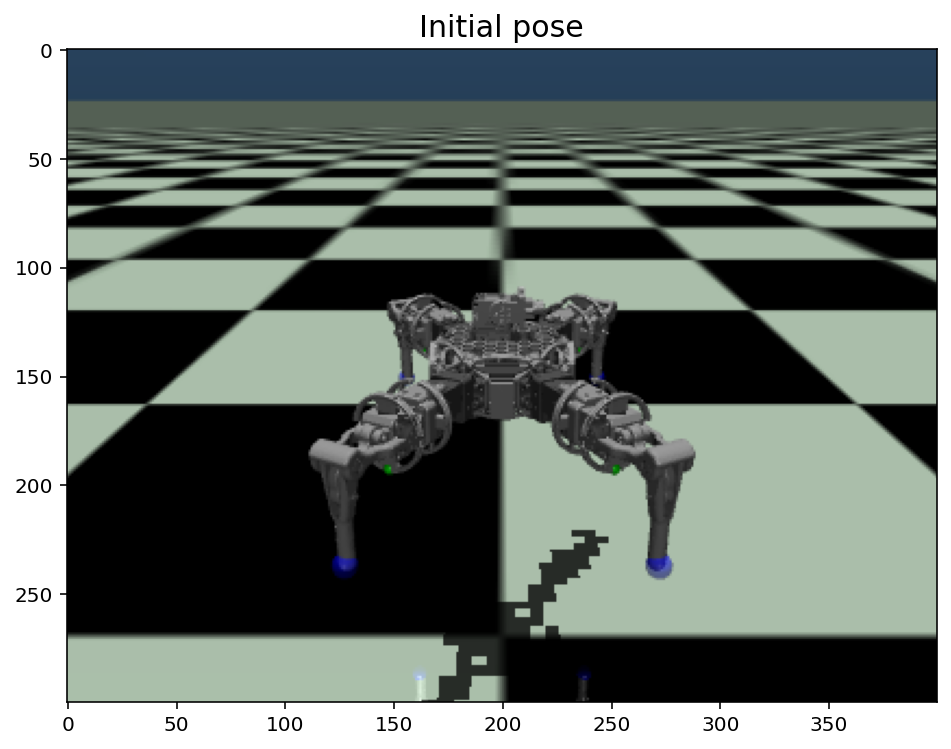

In [3]:
env.plot_scene(figsize=(10,6),render_w=400,render_h=300,
               cam_distance=0.75,cam_elevation=-20,cam_lookat=env.get_p_body(body_name='torso'),
               title_str='Initial pose',title_fs=15,RETURN_IMG=False)

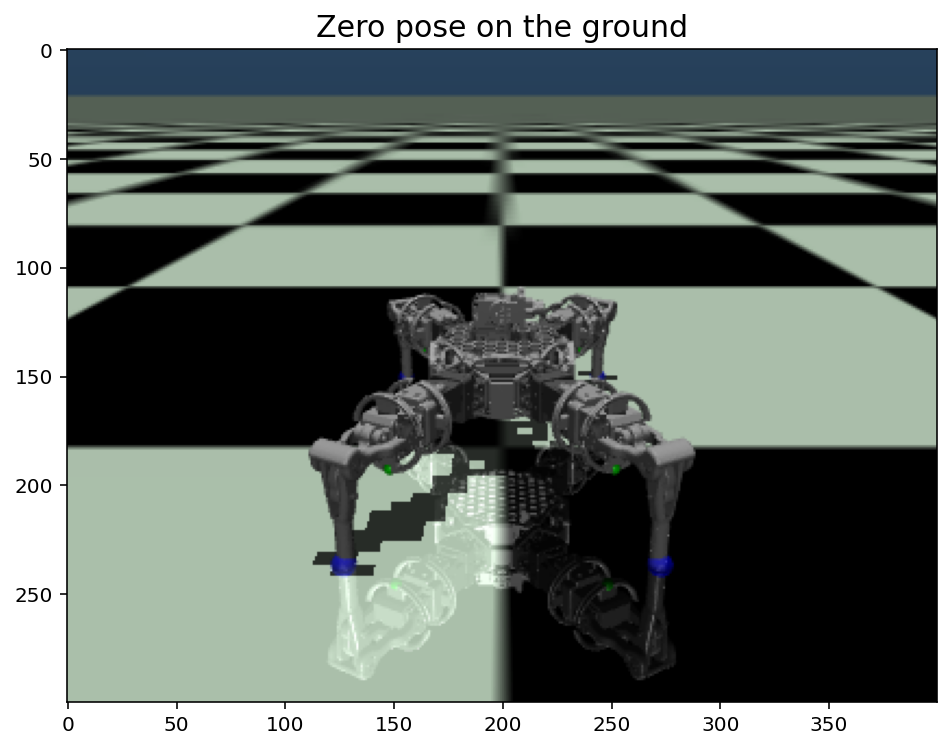

In [4]:
# q_init = np.random.randn(env.n_actuator)
q_init = np.zeros(env.n_actuator)
env.reset(RESET_SIM=True)
wait_until_snapbot_on_ground(env,PID,q_init=q_init,wait_sec=2.0)
env.plot_scene(figsize=(10,6),render_w=400,render_h=300,
               cam_distance=0.75,cam_elevation=-20,cam_lookat=env.get_p_body(body_name='torso'),
               title_str='Zero pose on the ground',title_fs=15,RETURN_IMG=False)

### Rollout from Gaussian random path

In [5]:
# Sample
traj_joints,traj_secs = GRP_prior.sample_one_traj(
    rand_type='Uniform',ss_x_min=ss_range[:,0],ss_x_max=ss_range[:,1],ss_margin=ss_margin)

In [6]:
def snapbot_rollout(env,PID,traj_joints,n_traj_repeat=5,DO_RENDER=True,
                    window_width=0.5,window_height=0.5,cam_distance=1.5,cam_elevation=-20,
                    cam_lookat=[1.0,0,-0.2],lookat_body=None,
                    TERMINATE_AFTER_FINISH=False):
    """
        Rollout of Snapbot
    """
    if DO_RENDER:
        env.init_viewer(TERMINATE_GLFW=True,INITIALIZE_GLFW=True,
                        window_width=window_width,window_height=window_height,
                        cam_distance=cam_distance,cam_elevation=cam_elevation,
                        cam_lookat=cam_lookat)
    wait_until_snapbot_on_ground(env,PID)
    PID.reset()
    L,cnt = traj_joints.shape[0],0
    sec_list    = np.zeros(shape=(int(L*n_traj_repeat)))
    q_curr_list = np.zeros(shape=(int(L*n_traj_repeat),env.n_actuator))
    q_trgt_list = np.zeros(shape=(int(L*n_traj_repeat),env.n_actuator))
    torque_list = np.zeros(shape=(int(L*n_traj_repeat),env.n_actuator))
    xyrad_list  = np.zeros(shape=(int(L*n_traj_repeat),3))
    for r_idx in range(n_traj_repeat): # repeat
        for tick in range(L): # for each tick in trajectory
            sec,q_curr,q_trgt=cnt*env.dt,get_snapbot_q(env),traj_joints[tick,:]
            PID.update(x_trgt=q_trgt,t_curr=sec,x_curr=get_snapbot_q(env),VERBOSE=False)
            torque = PID.out()
            if DO_RENDER:
                env.step(ctrl=torque,ctrl_idxs=None)
                if lookat_body is not None:
                    env.render(render_speedup=1.0,cam_lookat=env.get_p_body(body_name=lookat_body))
                elif cam_lookat is not None:
                    env.render(render_speedup=1.0,cam_lookat=cam_lookat)
                else:
                    env.render(render_speedup=1.0)
            else:
                env.step(torque=torque,TORQUE_TO_REV_JOINT=False)
            p_torso = env.get_p_body(body_name='torso')
            heading_rad = r2rpy(env.get_R_body(body_name='torso'),unit='rad')[2]
            # Append
            sec_list[cnt],q_curr_list[cnt,:],q_trgt_list[cnt,:] = sec,q_curr,q_trgt
            torque_list[cnt,:],xyrad_list[cnt,:] = torque,np.concatenate((p_torso[:2],[heading_rad]))
            cnt = cnt + 1 # tick
    res = {'sec_list':sec_list,'q_curr_list':q_curr_list,'q_trgt_list':q_trgt_list,
           'torque_list':torque_list,'xyrad_list':xyrad_list}
    if DO_RENDER and TERMINATE_AFTER_FINISH:
        env.terminate_viewer()
    return res
print ("Done.")

Done.


In [7]:
res = snapbot_rollout(env,PID,traj_joints,n_traj_repeat=5,
                      DO_RENDER=True,TERMINATE_AFTER_FINISH=True,lookat_body='torso')

Creating window glfw
Creating window glfw


2022-08-19 01:21:20.806 python3.8[50043:1472024] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


### Plot joint tracking results

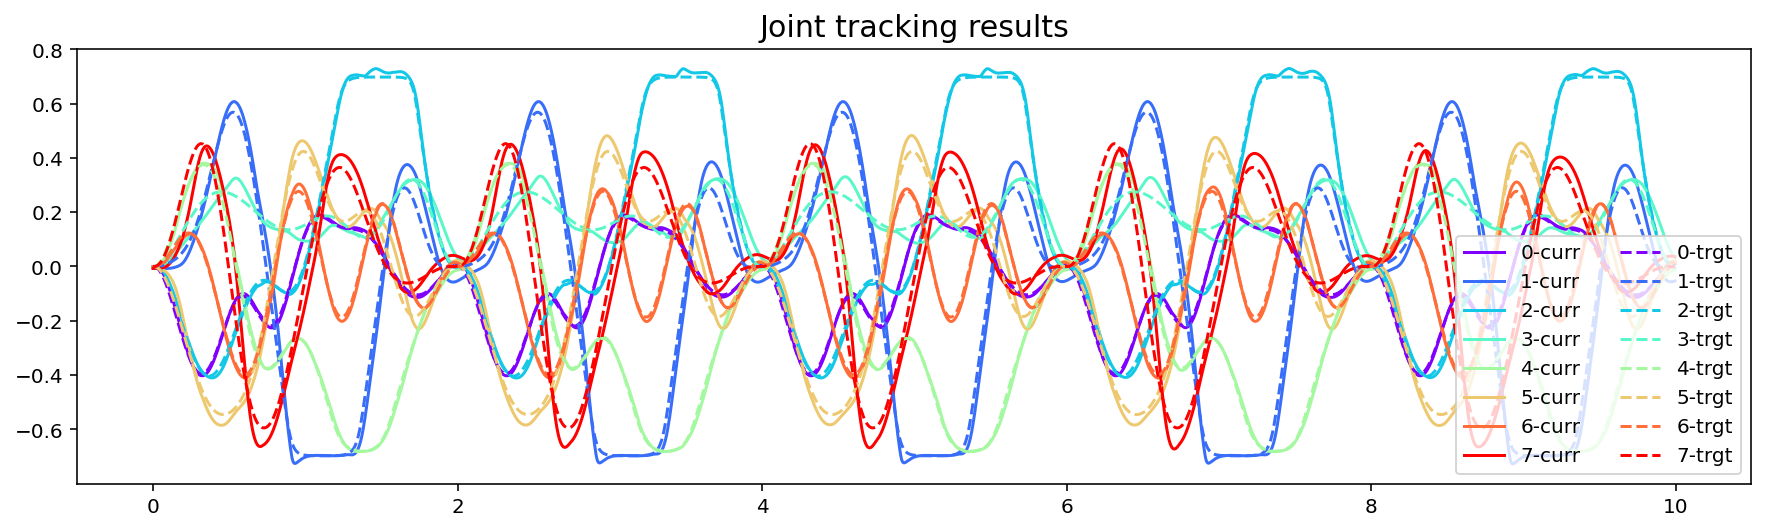

In [8]:
plt.figure(figsize=(15,4))
colors = get_colors(res['q_curr_list'].shape[1])
for d_idx in range(res['q_curr_list'].shape[1]):
    color = colors[d_idx]
    plt.plot(res['sec_list'],res['q_curr_list'][:,d_idx],'-',color=color,label='%d-curr'%(d_idx))
for d_idx in range(res['q_curr_list'].shape[1]):
    color = colors[d_idx]
    plt.plot(res['sec_list'],res['q_trgt_list'][:,d_idx],'--',color=color,label='%d-trgt'%(d_idx))
plt.legend(fontsize=10,ncol=2,loc='lower right')
plt.title('Joint tracking results',fontsize=15)
plt.show()

### Plot top-down trajectory

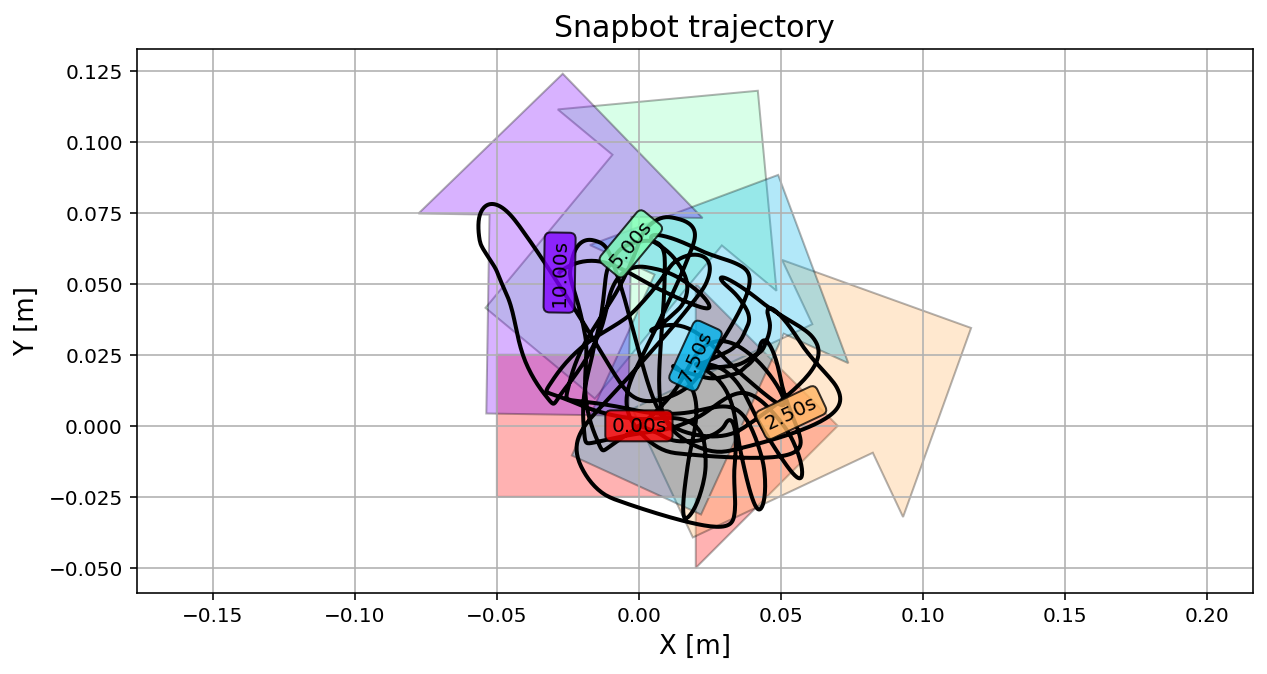

In [9]:
plot_topdown_trajectory(
    sec_list=res['sec_list'],xyrad_list=res['xyrad_list'],
    n_arrow=5,scale=0.1,cm=plt.cm.rainbow_r,figsize=(10,5),title_str='Snapbot trajectory')

### Rollout from the GRP-interpolated trajectory

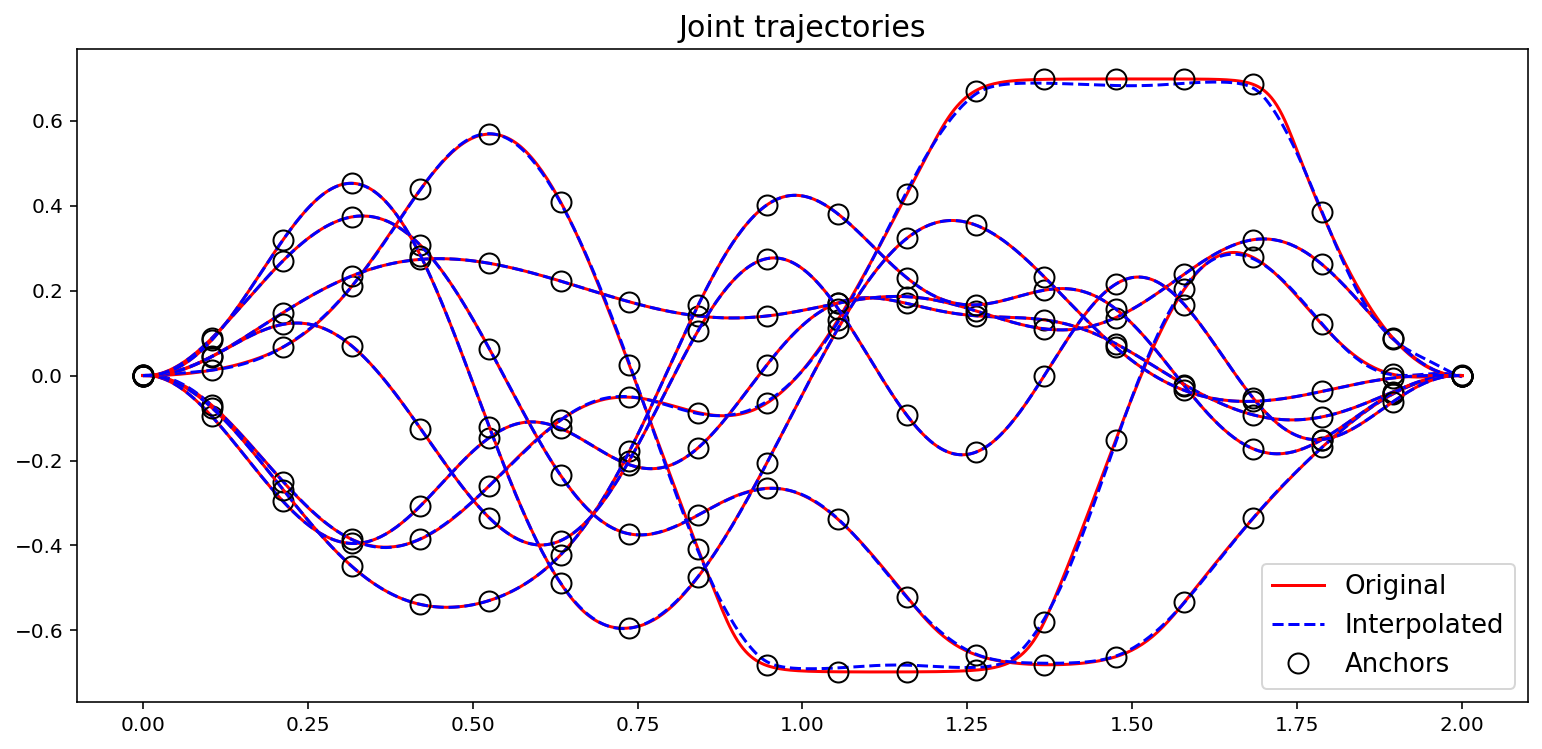

Creating window glfw
Creating window glfw


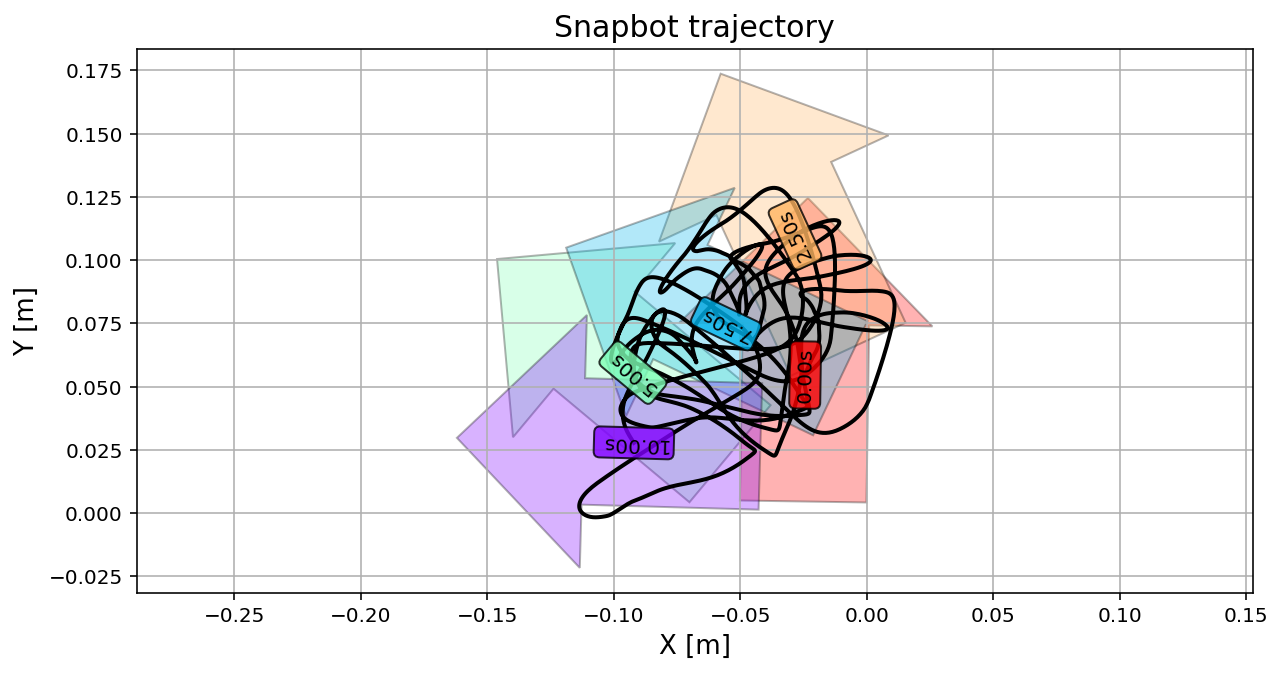

In [10]:
t_anchor,x_anchor = get_anchors_from_traj(traj_secs,traj_joints,n_anchor=20)
traj_joints_intp = GRP_posterior.interpolate(
    t_anchor=t_anchor,x_anchor=x_anchor,t_test=traj_secs,hyp={'g':1,'l':1/4,'w':1e-8},
    APPLY_EPSRU=True,t_eps=0.01,
    x_min=ss_range[:,0],x_max=ss_range[:,1],margin=3.0*np.pi/180.0)
# Plot joint trajectories
plt.figure(figsize=(13,6))
for i_idx in range(env.n_actuator):
    plt.plot(traj_secs,traj_joints[:,i_idx],'-',color='r',label='Original')
    plt.plot(traj_secs,traj_joints_intp[:,i_idx],'--',color='b',label='Interpolated')
    plt.plot(t_anchor,x_anchor[:,i_idx],'o',color='k',ms=10,mfc='none',label='Anchors')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),fontsize=13,loc='lower right')
plt.title('Joint trajectories',fontsize=15)
plt.show()
# Rollout
res_intp = snapbot_rollout(env,PID,traj_joints_intp,n_traj_repeat=5,
                           DO_RENDER=True,TERMINATE_AFTER_FINISH=True,lookat_body='torso')
plot_topdown_trajectory(
    sec_list=res_intp['sec_list'],xyrad_list=res_intp['xyrad_list'],
    n_arrow=5,scale=0.1,cm=plt.cm.rainbow_r,figsize=(10,5),title_str='Snapbot trajectory')